# Lattice constant optimization for a CsCl Structure

Below we want to find the ideal lattice constant for `ScAl` in a CsCl structure, a body center cubic structure with the `Sc` atoms at the corners and a `Al` atom at the center. 

We do this by calculating the energy of the system for a range of values for the lattice constant and by curve fitting finding the minimum lattice constant. 

In [67]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

## Visualization
We start with writing the template quantum espresso input file. To make sure it's what we want we can visualize the unit cell by reading in the file into `ase` and then calling `view` which brings up a rotable viewer. We can then write it out to a  `.cif` file to view in another viewer like `Vesta`. 

In [68]:
from ase.io import read, write
from ase.visualize import view

In [69]:
ScAl = read('ScAl.lattice.in')

In [70]:
view(ScAl)

<Popen: returncode: None args: ['/Users/vinhtran/opt/anaconda3/bin/python', ...>

In [41]:
write('ScAl.cif', ScAl)

## Quantum Espresso Helper Files
We define a few helper files
1. `Parse_output` which parses through the quantum espresso output file and extracts relevant quantities like the total energy or lattice constant and stores in a python `dict` which is then returned
2. `lattice_subs` which parses through the quantum espresso input file and updates the lattice constant at each iteration, ie, it updates `celldm(1)`

In [71]:
def parse_output(outfile):
    """ Parses the quantum espresso output file
        Returns a dictionary with relevants in key-value pairs
        such as {'energy': energy_value}
    """
    
    with open(outfile, 'r') as outf:
        for line in outf:
            if (line.lower().startswith('     lattice parameter (alat)')):
                lattice_constant = float(line.split()[-2]) * 0.529177
            if (line.lower().startswith('!    total energy')):
                total_energy = float(line.split()[-2]) * 13.605698066
    
    result = {'energy': total_energy, 'lattice': lattice_constant}
    return result

In [72]:
def lattice_subs(file, lattice_parameter, offset = '0'):
    """ opens input file file and changes value for lattice constant """
    
    # check for proper input 
    assert type(lattice_parameter) == 'int' or 'numpy.int64', 'Provide k-points input as int or numpy.int64' 
    lat_string = "    celldm(1) = " + str(lattice_parameter) + "\n"
    
    # open the file 
    with open(file,'r') as input_file:
        lines = input_file.readlines()
    with open(file, 'w') as input_file:
        for line in lines:
            if line.split()[0] == 'celldm(1)':
                # write the k_points string 
                input_file.write(lat_string)
            else:
                input_file.write(line)  

In [73]:
lattice_array = np.linspace(10.00, 12.00, 10)

In [74]:
def problem_4(lattice_array):
    """ performs problem 4 calculations 
        finds energy as a function of lattice points 
    """
    
    # declare force array of same size as cut off array 
    energy_array = np.zeros(len(lattice_array))
    
    for i in range(len(lattice_array)):
        # update input file 
        lattice_subs("ScAl.lattice.in", lattice_array[i])
        
        # call pw.x 
        subprocess.run('pw.x -in ScAl.lattice.in > ScAl.lattice.out', shell=True)
        
        # parse output file 
        result = parse_output('ScAl.lattice.out')
        
        # get force and append to array 
        energy_array[i] = result['energy']
        
    return energy_array

In [58]:
energy = problem_4(lattice_array)

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_DIVIDE_BY_ZERO IEEE_OVERFLOW_FLAG IEEE_UNDERFLOW_FLAG
Note: The following floatin

## Initial Plot
- Taking the data output and plotting it, we see a minimum at around 10.7 Bohr. To find the precise value for this minimum we fit the data to the Murnaghan equation of state defined below. 

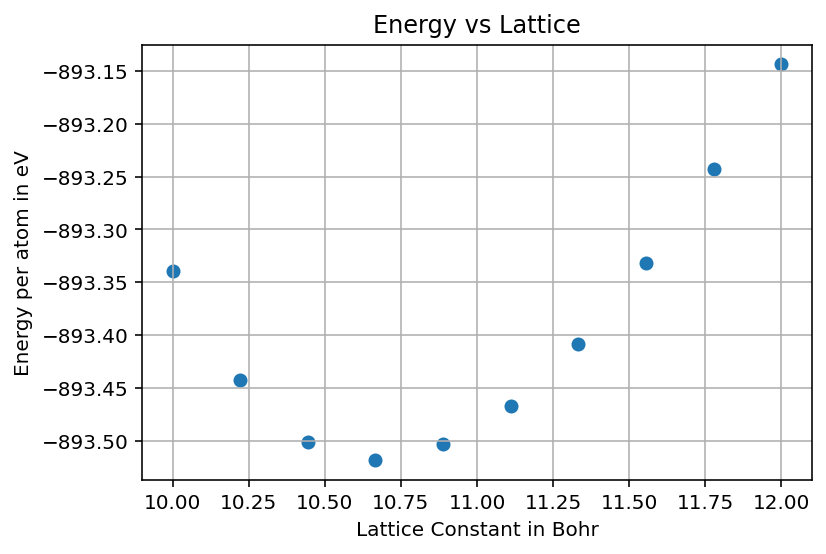

In [77]:
plt.scatter(lattice_array, energy/8)
plt.grid() 
plt.xlabel('Lattice Constant in Bohr')
plt.ylabel('Energy per atom in eV')
plt.title('Energy vs Lattice')
plt.show() 

## Fitting: Murnaghan Equation of State

In [78]:
def murnaghan(a, a0, B0, B0_prime, E0):
    coeff_1 = 9*B0*a0**3/16/4
    brac_1 = ((a0/a)**2 - 1)**3 * B0_prime 
    brac_2 = ((a0/a)**2 - 1)**2 * (6 - 4*(a0/a)**2)
    return E0 + coeff_1 * (brac_1 + brac_2)

In [81]:
from scipy.optimize import curve_fit
popt_m, pcov_m = curve_fit(murnaghan, lattice_array, energy/8, p0 = [10.00, 2.68, 4.10, -5.81340065e+03])

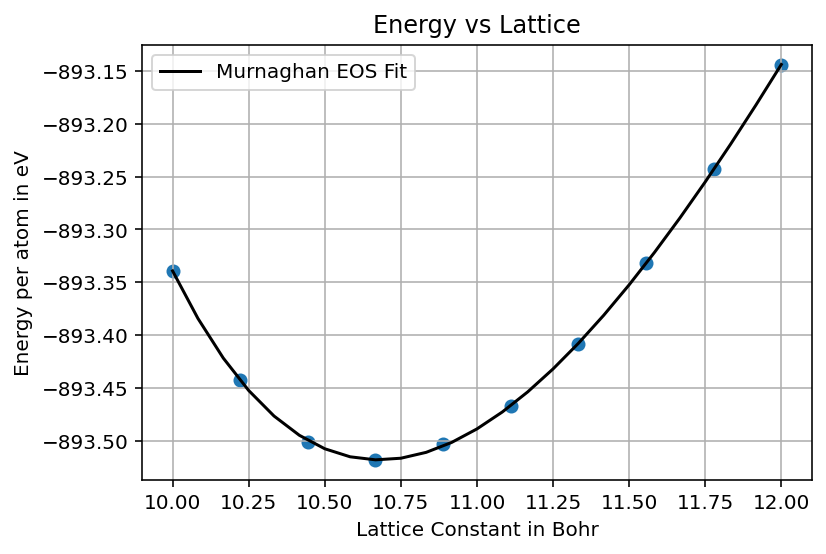

In [82]:
plt.scatter(lattice_array, energy/8)
plt.plot(np.linspace(10.00, 12.00, 25), murnaghan(np.linspace(10.00, 12.00, 25), *popt_m),\
         label = 'Murnaghan EOS Fit', color = 'black')
plt.legend()
plt.grid() 
plt.xlabel('Lattice Constant in Bohr')
plt.ylabel('Energy per atom in eV')
plt.title('Energy vs Lattice')
plt.savefig('energy_vs_lattice.pdf')

## Predicted Lattice Constant 

In [64]:
popt_m[0]

10.678518622687173